In [1]:
#| default_exp wrapping_pymeshlab

In [2]:
#| export

from blender_tissue_cartography import io as tcio
from blender_tissue_cartography import registration as tcreg
from blender_tissue_cartography import interface_pymeshlab as intmsl
import numpy as np
from copy import deepcopy
import warnings
import pymeshlab

Unable to load the following plugins:

	libio_e57.so: libio_e57.so does not seem to be a Qt Plugin.

Cannot load library /home/nikolas/Programs/miniconda3/envs/blender-tissue-cartography/lib/python3.11/site-packages/pymeshlab/lib/plugins/libio_e57.so: (/lib/x86_64-linux-gnu/libp11-kit.so.0: undefined symbol: ffi_type_pointer, version LIBFFI_BASE_7.0)



In [4]:
from blender_tissue_cartography import interpolation as tcinterp
from skimage import transform
from scipy import stats, spatial, linalg
import os
import matplotlib.pyplot as plt
import mcubes

In [5]:
from tqdm.notebook import tqdm
from importlib import reload

In [6]:
np.set_printoptions(suppress=True)

## Automated wrapping

This notebook builds the tools for automated mesh wrapping (setting vertex positions of one mesh to the closest point on another mesh). This is a part of the pipeline for dynamic surfaces discussed in notebook 3a.

We have two separate notebooks  - and modules -  for wrapping, depending on whether we use `pymeshlab` or `open3d`. The reason for this is that `pymeshlab` may not be available on all platforms.

## Loading and segmenting the dataset

We will use the same dataset - a _Drosophila_ example - as in tutorial 2.

In [7]:
metadata_dict = {'filename': 'wrapping_example/Drosophila_CAAX-mCherry',
                 'resolution_in_microns': (1.05, 1.05, 1.05), # lightsheet data has isotropic resolution
                 'subsampling_factors': (1/2, 1/2, 1/2),
                }

In [8]:
image = tcio.adjust_axis_order(tcio.imread(f"{metadata_dict['filename']}.tif"))
print("image shape:", image.shape) # image shape - spatial axes are in z-x-y order

image shape: (1, 190, 509, 188)


## 3d segmentation / Meshing

Already done - we'll just read in the results.

## Registration

Using the tools from notebook 3a, compute an affine registration of the reference onto the data mesh.

In [9]:
mesh_data = tcio.ObjMesh.read_obj(f"{metadata_dict['filename']}_mesh_remeshed.obj")
mesh_ref = tcio.ObjMesh.read_obj(f"wrapping_example/Drosophila_reference.obj")

In [10]:
trafo_centroid_intertia, _ = tcreg.align_by_centroid_and_intertia(mesh_ref.vertices, mesh_data.vertices,
                                                                  q=0.01, shear=True)

trafo_icp, _, _ = tcreg.icp(mesh_ref.vertices, mesh_data.vertices, initial=trafo_centroid_intertia,
                            threshold=1e-4, max_iterations=100, scale=True, n_samples=5000)

In [11]:
# we now save the pre-registered mesh. Note that we want to transform both our
# mesh coordinates and the corresponding normals, as well as potentially flip face orientation

mesh_registered = mesh_ref.apply_affine_to_mesh(trafo_icp)
mesh_registered.name = "Drosophila_reference_preregistered"
mesh_registered.write_obj(f"wrapping_example/Drosophila_reference_registered.obj")

## Procedural wrapping

We can also automatically wrap using blender's python API. Let's see how it works. 
- `trimesh.proximity` appears not feasible - way too slow, 15s for 1k vertices.
- Annoyingly, blender scripts cannot be directly run from python. It must be done from within the blender script window. The goal here would be to write a script that can be either easily run in blender, or run from the command line (also possible via python's `shutil`).
- `open3d` is another option - see [here](https://www.open3d.org/docs/latest/tutorial/geometry/distance_queries.html). However, this adds another big dependency to the project.
- `pymeshlab`'s `transfer_attributes_per_vertex`

We will use the interfacing tools from notebooks 1b, 1c which allow us to convert our `ObjMesh` into `pymeshlab` or `open3d` classes.

### `pymeshlab`

GUI: "Filters -> Sampling -> Vertex Attribute Transfer". Python: `transfer_attributes_per_vertex`.

Note: meshlab default io discards UV information. We have to use our own class.

In [12]:
#| export

def shrinkwrap_pymeshlab(mesh_source, mesh_target, n_iter_smooth_target=10, n_iter_smooth_wrapped=10):
    """
    Shrink-wrap the source mesh onto the target mesh using pymeshlab.
    
    Sets the vertex positions of mesh_source to the closes point on the surface of mesh_target (not necessarily
    a vertex). Optionally, smoothes the target mesh and the wrapped mesh for smoother results using a Taubin
    filter (recommended). Gives out a warning if the shrink-wrapping flips any vertex normals, which can
    indicate problems.
    
    The shrinkwrapped mesh still has the UV maps of the source mesh, and so can be used to compute
    cartographic projections.
    
    Parameters
    ----------
    mesh_source : tcio.ObjMesh
        Mesh to be deformed
    mesh_target : tcio.ObjMesh
        Mesh with target shape
    n_iter_smooth_target : int, default 10
        Taubin smoothing iterations for target
    n_iter_smooth_wrapped : int, default 10
        Taubin smoothing iterations for shrinkwrapped mesh, after shrinkwrapping

    Returns
    -------
    mesh_wrapped : tcio.ObjMesh

    """
    mesh_target_msl = intmsl.convert_to_pymeshlab(mesh_target)
    mesh_source_msl = intmsl.convert_to_pymeshlab(mesh_source)
    # create MeshSet and add the two meshes
    ms = pymeshlab.MeshSet()
    ms.add_mesh(mesh_target_msl)
    ms.add_mesh(mesh_source_msl)
    # taubin smoothing of target
    ms.set_current_mesh(0)
    ms.apply_coord_taubin_smoothing(stepsmoothnum=n_iter_smooth_target)
    # wrapping - note that the source-target convention is incorrectly documented
    ms.transfer_attributes_per_vertex(sourcemesh=0, targetmesh=1, vertexsampling=False, geomtransfer=True,
                                      normaltransfer=True, upperbound=pymeshlab.PercentageValue(100))
    # taubin smoothing of wrapped source
    ms.set_current_mesh(1)
    ms.apply_coord_taubin_smoothing(stepsmoothnum=n_iter_smooth_target)
    mesh_wrapped = intmsl.convert_from_pymeshlab(ms.mesh(1))
    # check if any normals were flipped
    dots = np.einsum("vi,vi->v", mesh_source.vertex_normals, mesh_wrapped.vertex_normals)
    if np.sum(dots < 0) > 0:
        warnings.warn(f"Warning: {np.sum(dots<0)} normal(s) flipped during shrink-wrapping")
    return mesh_wrapped

In [13]:
# Load source and target mesh
mesh_target = tcio.ObjMesh.read_obj("wrapping_example/Drosophila_CAAX-mCherry_mesh_remeshed.obj")
mesh_source = tcio.ObjMesh.read_obj("wrapping_example/Drosophila_reference_registered.obj")

In [14]:
mesh_wrapped_msl = shrinkwrap_pymeshlab(mesh_source, mesh_target,
                                        n_iter_smooth_target=10, n_iter_smooth_wrapped=10)

In [19]:
%%time
mesh_target_msl = intmsl.convert_to_pymeshlab(mesh_target)
mesh_source_msl = intmsl.convert_to_pymeshlab(mesh_source)
mesh_wrapped = intmsl.convert_from_pymeshlab(mesh_source_msl)

CPU times: user 1.17 s, sys: 15.9 ms, total: 1.19 s
Wall time: 1.19 s


In [15]:
%%time
mesh_wrapped_msl = shrinkwrap_pymeshlab(mesh_source, mesh_target,
                                        n_iter_smooth_target=10, n_iter_smooth_wrapped=10)

CPU times: user 1.74 s, sys: 23.8 ms, total: 1.76 s
Wall time: 1.76 s


In [14]:
mesh_wrapped_msl.write_obj("wrapping_example/Drosophila_reference_wrapped_msl.obj")

## UV projection

To see how well all of this has worked, let's use the wrapped mesh to generate UV projections.

In [107]:
normal_offsets = np.array([-4, -2, 0, 2]) ##np.linspace(-5, 2, 8) # in microns
metadata_dict["normal_offsets"] = normal_offsets # add the info to the metadata
uv_grid_steps = 512

In [108]:
tcio.save_dict_to_json(f"{metadata_dict['filename']}_metadata.json", metadata_dict)

In [110]:
projected_data_wrapped, projected_coordinates_wrapped, projected_normals_wrapped = tcinterp.create_cartographic_projections(
    image=f"{metadata_dict['filename']}.tif",
    mesh=f"wrapping_example/Drosophila_reference_wrapped_msl.obj",
    resolution=metadata_dict["resolution_in_microns"],
    normal_offsets=normal_offsets,
    uv_grid_steps=uv_grid_steps)

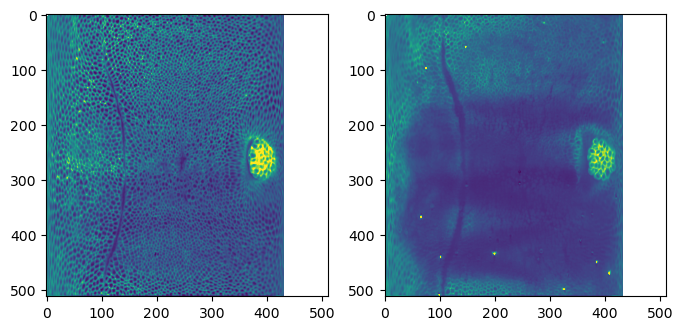

In [112]:
# show the projected data - looks good!

fig, (ax1, ax2) = plt.subplots(figsize=(8,8), ncols=2)
ax1.imshow(projected_data_wrapped[0, 0], vmax=10000)
ax2.imshow(projected_data_wrapped[0, 2], vmax=10000)